# Calculations for Missile Launch Acceleration
Last update: 29 Sept 2017

**Abstract:** The python code in this notebook will calculate the launch acceleration of missile launched horizontally from an aircraft.

**Introduction:** The launch acceleration is an important parameter for the arming environment of safe and arm devices.  This notebook will calculate the launch acceleration for a rail launched missile.  Acceleration at a basic level is force divided by mass.  The force is supplied by the rocket motor, which is reduced by drag and the mass is the weight of the missile.  This notebook will calculate the drag over a range of altitudes and Mach numbers and then calculate the launch acceleration.

As the missile leaves the launcher, its velocity will increase and so will the drag.  The acceleration over the first three seconds of flight is calculated. The acceleration profile over this time interval is important because Missile acceleration after first motion from time = 0 to time = 3 seconds is also part of the arming environment. 

**Array variables used:**  
alt: altitude array, 0 to 50,000 meters  
rho: pressure array in Pa, as a function of altitude  
T: temperature array in C,  as a function of altitude  
air_density: air density array in kg/m^3, as a function of altitude

**Scope:** These calculations are primarily for rail launched missile.  Rocket motor thrust is considered a step function at t=0.  Drag coefficient versus Mach number is a educated guess. Calculations cover the following ranges: Altitude can range from 0 to 50,000 meters and mach number can range from 0.2 to 3.  Standard dry air is assumed. Some inputs are in inches and pounds and these are converted to the International System of Units (SI) and the calculations are performed in SI units, kg, m & s.

**Assumptions:** The following parameters are assumed since actual data was not available.
- Drag force vs Mach:  The drag force vs Mach curve is a re-creation of the a plot simular to the one found [here](http://what-when-how.com/space-science-and-technology/rocket-propulsion-theory/).  
- Rocket motor propellant weight: Rocket motor weight was found by search the internet and the propellant weight was assumed to be 75% of the motor weight.
- Propellant burn rate:  As propellant mass is converted to reaction mass, the weight of the rocket motor decreases.  This change in mass is modeled as linearly decreasing to zero over 10 seconds.
- Altitude and Mach range:  The altitude and Mach number for a missile launch was modeled over a range of altitudes from 1500 to 15,000 meters and Mach numbers from 0.2 to 2.
- Thrust: Rocket motor thrust is a critical parameter.  The thrust is assumed to be constant over as least the first 3 seconds of flight.  The thrust can be set to different values in order to calculate the acceleration.

**Analysis method:**  The calculations proceed as follows:
- find the density of air as a function of altitude
- calculate the drag force
- calculate the acceleration and convert to gravity units for a given motor thrust
- plot the results over a range of altitudes and Mach numbers
- calculate the acceleration over the first 3 seconds of flight at worst case altitude and Mach number


## Density of air
The [density of air](https://en.wikipedia.org/wiki/Density_of_air) ρ (Greek: rho) (air density) is the mass per unit volume of Earth's atmosphere. Air density, like air pressure, decreases with increasing altitude. It also changes with variation in temperature and humidity. At sea level and at 15°C air has a density of approximately 1.225 kg/m^3.

$p_0$ = sea level standard atmospheric pressure, 101.325 kPa  
$T_0$ = sea level standard temperature, 288.15 K  
R = ideal (universal) gas constant, 8.31447 J/(mol·K)  
M = molar mass of dry air, 0.0289644 kg/mol

Density can then be calculated according to a molar form of the ideal gas law:  
$density = \frac{p*M}{R*T}$  
where:  
M = molar mass  
R = ideal gas constant  
T = absolute temperature  
p = absolute pressure

## Earth's atmosphere
The Earth's atmosphere is an extremely thin sheet of air extending from the surface of the Earth to the edge of space.  

Standard Atmosphere:  
$p_0 = 101.325 kPa$  
$T_0 = 288.15 K$  
$\rho_0 = 1.225 kg/m^3$

The [model](https://www.grc.nasa.gov/www/k-12/airplane/atmosmet.html) has three zones with separate curve fits for the troposphere, the lower stratosphere, and the upper stratosphere.

### Troposphere
The troposphere runs from the surface of the Earth to 11,000 meters. In the troposphere, the temperature decreases linearly and the pressure decreases exponentially. The rate of temperature decrease is called the lapse rate. For the temperature T and the pressure p, the metric units curve fits for the troposphere are:  
$T = 15.04 - .00649 * h$  
$p = 101.29 * [\frac{T + 273.1}{288.08}]^{5.256}$  
where the temperature is given in Celsius degrees, the pressure in kilo-Pascals and h is the altitude in meters.

### Lower Stratosphere
The lower stratosphere runs from 11,000 meters to 25,000 meters. In the lower stratosphere the temperature is constant and the pressure decreases exponentially. The metric units curve fits for the lower stratosphere are:  
$T = -56.46$  
$p = 22.65*e^{1.73-.000157*h}$

### Upper Stratosphere
The upper stratosphere model is used for altitudes above 25,000 meters. In the upper stratosphere the temperature increases slightly and the pressure decreases exponentially. The metric units curve fits for the upper stratosphere are:  
$T = -131.21 + .00299 * h$  
$p = 2.488 * [\frac{T + 273.1}{216.6}]^{-11.388}$

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
alt = np.linspace(0, 50000, num=30, endpoint=True)
T = np.zeros(len(alt))  # temperature, units of degrees C
rho = np.zeros(len(alt))   # pressure as a function of temperature, units of kPa

# calculate the pressure and temperature as a function of altitude
for i in range(len(alt)):
    if alt[i] <= 11000:  # The troposphere runs from the surface of the Earth to 11,000 meters.
        T[i] =  15.04 - .00649 * alt[i]
        rho[i] = 101.29 * ((T[i] + 273.1)/288.08)**5.256
    if (alt[i] > 11000) and (alt[i] <= 25000): #The lower stratosphere runs from 11,000 meters to 25,000 meters
        T[i] = -56.46  # a constant
        rho[i] = 22.65 * np.exp(1.73 - .000157 * alt[i])
    if alt[i] > 25000:  # The upper stratosphere model is used for altitudes above 25,000 meters.
        T[i] = -131.21 + 0.00299 * alt[i]
        rho[i] = 2.488 * ((T[i] + 273.1)/ 216.6)**-11.388
# convert rho from kPa to Pa
rho *= 1000

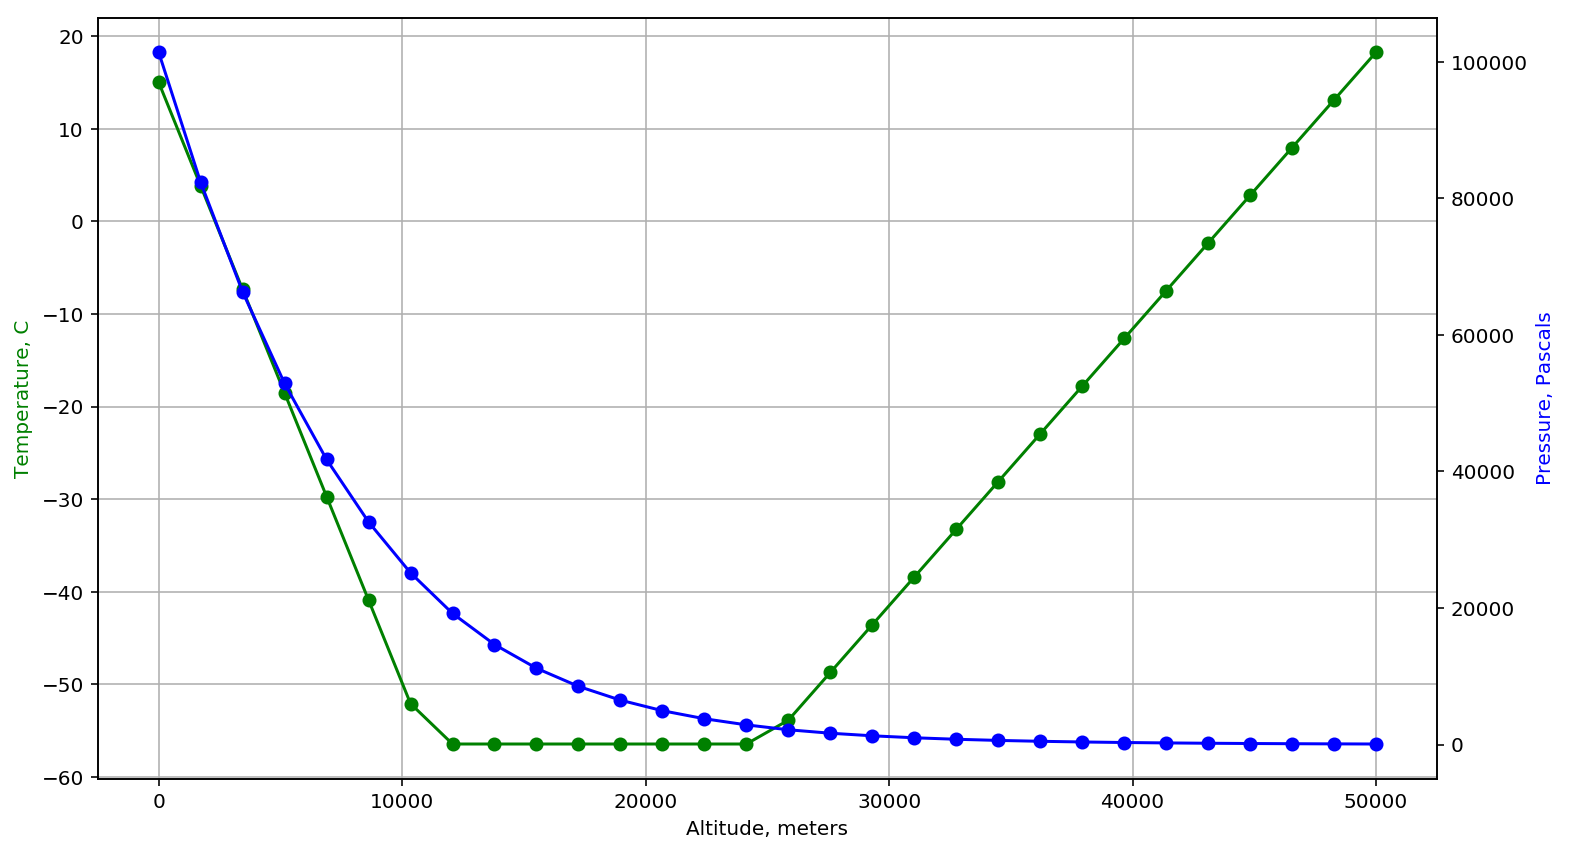

In [3]:
# plot the temperature and pressure vs altitude
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(alt, T,'g-o')
ax2.plot(alt, rho,'b-o')
ax1.set_xlabel('Altitude, meters')
ax1.set_ylabel('Temperature, C', color='g')
ax2.set_ylabel('Pressure, Pascals', color='b')
ax1.grid()  # put grid marks on temperature axis
plt.show()

### Molar mass of dry air
In chemistry, the molar mass M is a physical property defined as the mass of a given substance (chemical element or chemical compound) divided by the amount of substance. The base SI unit for molar mass is kg/mol. However, for historical reasons, molar masses are almost always expressed in g/mol. The molecular weight (or molar mass) of a substance is the mass of one mole of the substance, and can be calculated by summarizing the molar masses of all the atoms in the molecule.

**Components in Dry Air:**  Air is a mixture of several gases, where the two most dominant components in dry air are oxygen and nitrogen. Oxygen has a molar mass of 16 g/mol and nitrogen has a molar mass of 14 g/mol. Since both of these elements are diatomic in air - O2 and N2, the molar mass of oxygen is 32 g/mol and the molar mass of nitrogen is 28 g/mol.  The average molar mass is equal to the sum of the mole fractions of each gas multiplied by the molar mass of that particular gas:  
$M_{mixture} = (x_1*M_1 + ......+ x_n*M_n)$  
where  
$x_i$ = mole fractions of each gas  
$M_i$ = the molar mass of each gas


| Components in Dry Air | Volume Ratio compared to Dry Air | Molar Mass M (g/mol) |
|-----------------------|----------------------------------|----------------------|
| Oxygen | 0.2095 | 32.00 |
| Nitrogen | 0.7809 |28.02 |
| Carbon dioxide | 0.0003 | 44.01 |
| Hydrogen | 0.0000005 | 2.02 |
| Argon | 0.00933 | 39.94 |
| Neon | 0.000018 | 20.18 |
| Helium | 0.000005 | 4.00 |
| Krypton | 0.000001 | 83.8 |
| Xenon | 0.09x10-6 | 131.29 |
The average molar mass of dry air is 28.97 g/mol.

In [4]:
# make a dataframe for the constituents of dry air
df = pd.DataFrame(columns=['element','Volume Ratio','Molar Mass'])
df.loc[0] = ['Oxygen',0.2095,32.00]
df.loc[1] = ['Nitrogen',0.7809,28.02]
df.loc[2] = ['Carbon dioxide',0.0003,44.01]
df.loc[3] = ['Hydrogen',0.0000005,2.02]
df.loc[4] = ['Argon',0.00933,39.94]
df.loc[5] = ['Neon',0.000018,20.18]
df.loc[6] = ['Helium',0.000005,4.00]
df.loc[7] = ['Krypton',0.000001,83.8]
df.loc[8] = ['Xenon',0.09e-6,131.29]

molar_mass_air = 0
for i in range(len(df)):
    molar_mass_air += df.loc[i,'Volume Ratio']*df.loc[i,'Molar Mass']

molar_mass_air /= 1000 # convert to kg/mol
print('molar mass of dry air: {:f} kg/mol'.format(molar_mass_air))

molar mass of dry air: 0.028971 kg/mol


### The ideal gas law
The ideal gas law, also called the general gas equation, is the equation of state of a hypothetical ideal gas. It is a good approximation of the behavior of many gases under many conditions, although it has several limitations. It was first stated by Émile Clapeyron in 1834 as a combination of the empirical Boyle's law, Charles's law and Avogadro's Law. The ideal gas law is often written as  
$PV=nRT$  
where:  
P is the pressure of the gas  
V is the volume of the gas  
n is the amount of substance of gas (in moles)  
R is the ideal, or universal, gas constant, equal to the product of the Boltzmann constant and the Avogadro constant  
T is the absolute temperature of the gas

This form of the ideal gas law is very useful because it links pressure, density, and temperature in a formula independent of the quantity of the considered gas.  
$density = \frac{molar mass*P}{R*T}$

At sea level and at 15 °C air has a density of approximately $1.225 \frac{kg}{m^3}$

In [5]:
# density of air at a given pressure and temperature
p = 101.325 # absolute pressure at sea level, kilo-Pascals
p *= 1000  # convert to Pa
t = 15 # temperature, units of C, need to convert to K when using in equations
# ideal gas constant
k = 1.38064852e-23 # Boltzmann constant, J/T, relates the average kinetic energy in a gas with the temperature of the gas
Na = 6.022140857e23 # Avogadro constant, 1/mol
R = k*Na  # 8.3144598 # ideal gas constant, J/(mol⋅T)
print('ideal gas constant: {:.5f} J/(mol⋅T)'.format(R))
d = p*molar_mass_air/(R*(t+273.1))
print('air density at {:,.0f} pa and {:.0f}C is {:.3f} kg/m^3'.format(p,t,d))

ideal gas constant: 8.31446 J/(mol⋅T)
air density at 101,325 pa and 15C is 1.225 kg/m^3


### Air density as a function of altitude

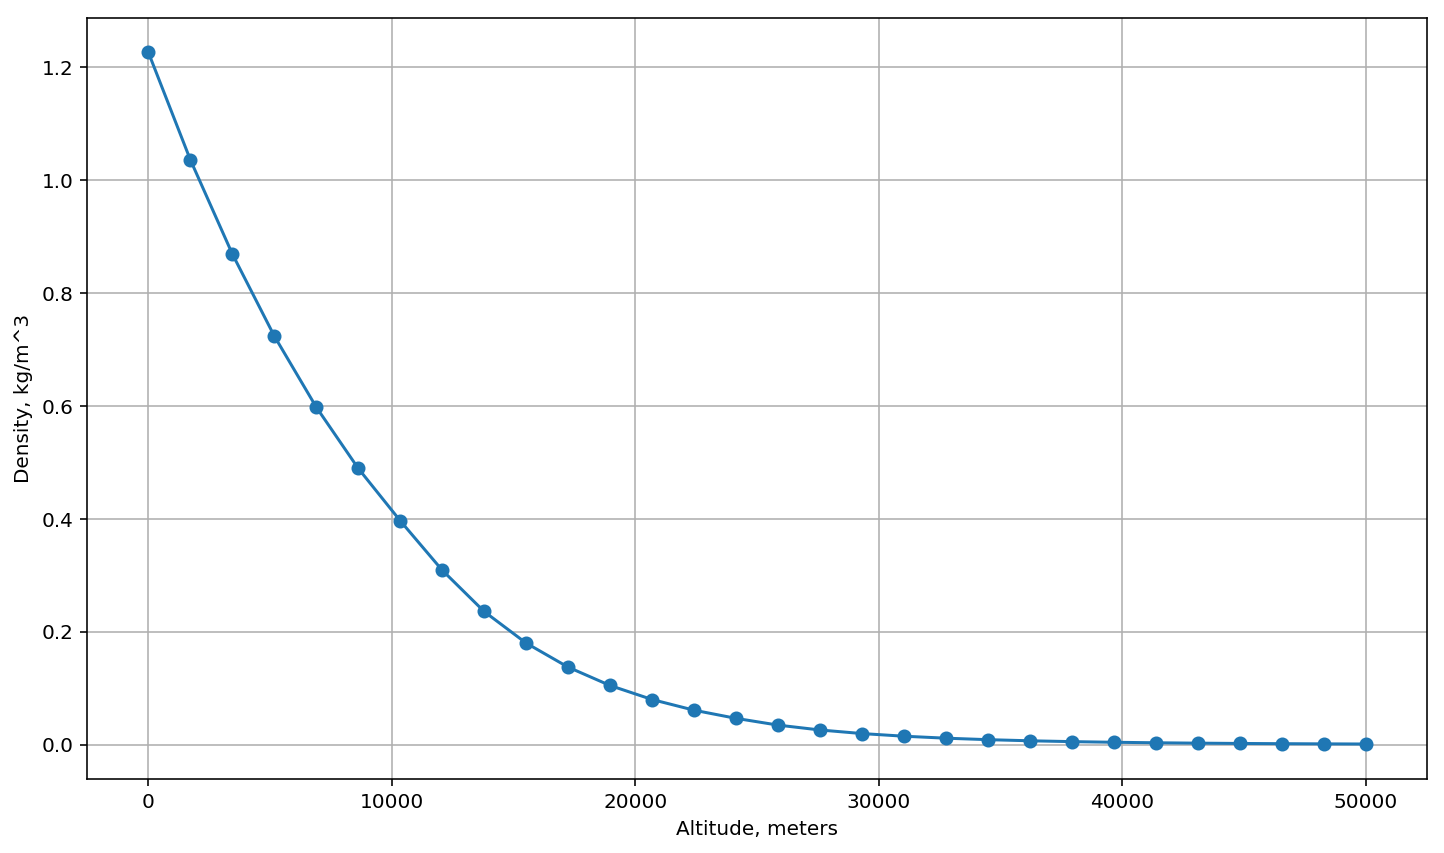

In [6]:
air_density = (rho)*molar_mass_air/(R*(T+273.1))
plt.plot(alt, air_density,'-o')
plt.xlabel('Altitude, meters')
plt.ylabel('Density, kg/m^3')
plt.grid()
plt.show()

### Inputs to missile acceleration model
Rocket motor thrust is the critical parameter.  The calculations that follow are at the given motor thrust.  The model needs to be re-run to investigate the effect of different motor thrusts.

The drag force vs Mach number curve is a re-creation of the a plot simular to the one found [here](http://what-when-how.com/space-science-and-technology/rocket-propulsion-theory/).  A few points were plotted and then a polynomial was fitted to the data.  20 evenly spaced points were then obtained from the polynomial.

In [7]:
motor_thrust_lbs = 8150  # Rocket motor thrust, pounds force
msl_weight_lbs = 783 # Weight of the missile in pounds
d_in = 10 # diameter of the missile, inches
# convert to SI units
motor_thrust = motor_thrust_lbs * 4.448221  # convert pounds force to Newtons
msl_weight = msl_weight_lbs * 0.453592  # convert msl weight to kg
area = np.pi*(d_in*0.0254)**2  # reference area, meters^2
# the drag coefficient data
drag_coef = np.array([ 0.25178887,  0.25727917,  0.2667809 ,  0.29157576,  0.33151054,
        0.3751851 ,  0.40855034,  0.42259789,  0.41653802,  0.39646125,
        0.37134516,  0.34878305,  0.33235726,  0.32153869,  0.31374898,
        0.30715263,  0.30223753,  0.30067404,  0.29972725,  0.29972725])
mach_num = np.array([ 0.2       ,  0.34736842,  0.49473684,  0.64210526,  0.78947368,
        0.93684211,  1.08421053,  1.23157895,  1.37894737,  1.52631579,
        1.67368421,  1.82105263,  1.96842105,  2.11578947,  2.26315789,
        2.41052632,  2.55789474,  2.70526316,  2.85263158,  3.])

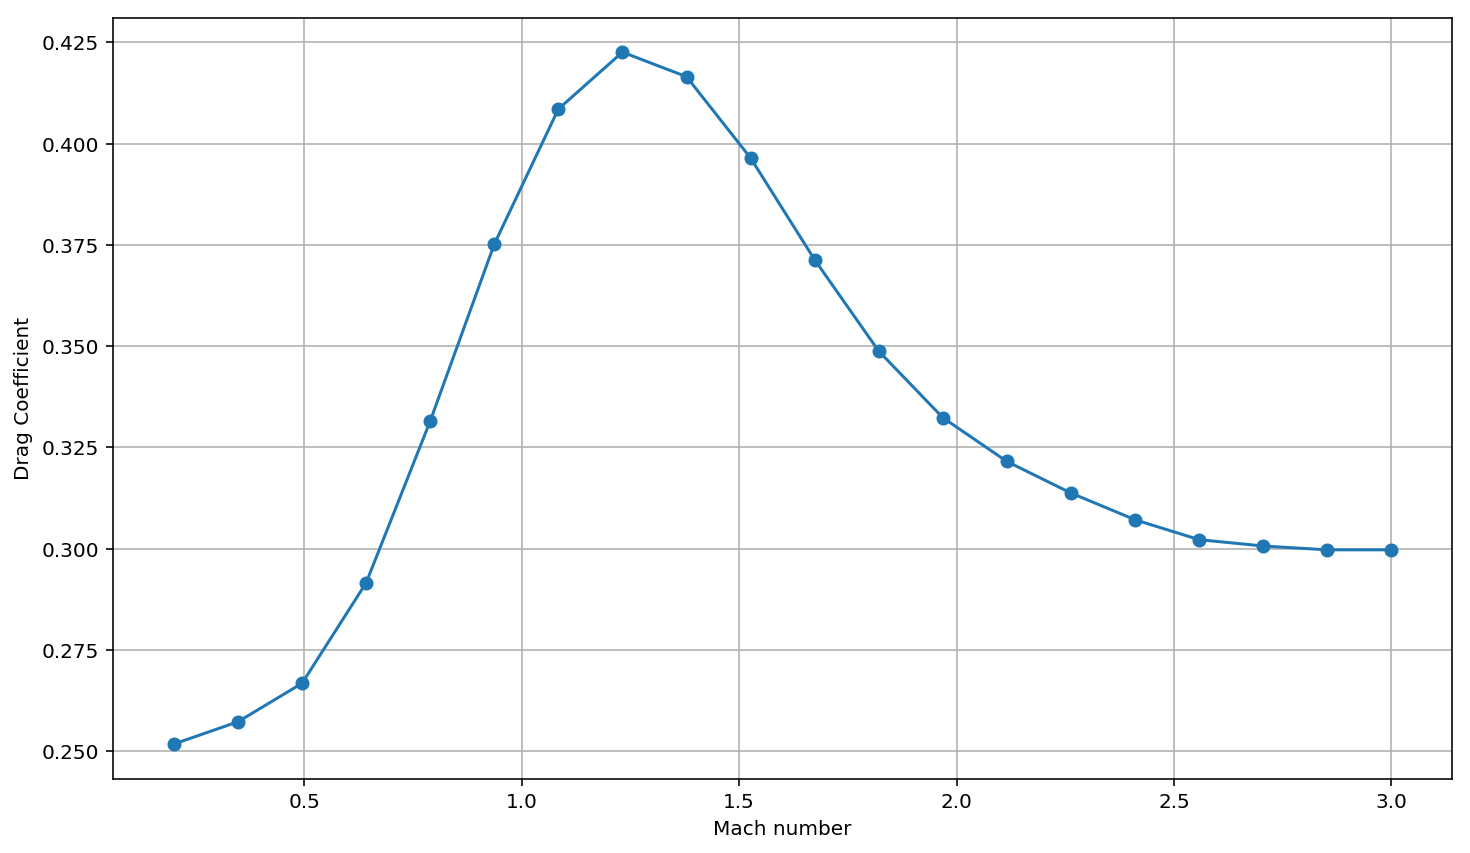

In [8]:
# plot drag coefficients
plt.plot(mach_num, drag_coef,'-o')
plt.xlabel('Mach number')
plt.ylabel('Drag Coefficient')
plt.grid()
#plt.show()
plt.savefig('Launch_Accel_drag_coeff.png', format='png', dpi=400)

## Calculate drag force
In fluid dynamics, the [drag equation](https://en.wikipedia.org/wiki/Drag_equation) is a formula used to calculate the force of drag experienced by an object due to movement through a fully enclosing fluid. The formula is accurate only under certain conditions: the objects must have a blunt form factor and the system must have a large enough Reynolds number to produce turbulence behind the object. The equation is:  
$F_{D}= \frac{1}{2}\rho*u^{2}*C_{D}*A$  
where:  
$F_{D}$ is the drag force, which is by definition the force component in the direction of the flow velocity  
$\rho$  is the mass density of the fluid  
u is the flow velocity relative to the object  
A is the reference area.  The reference area A is typically defined as the area of the orthographic projection of the object on a plane perpendicular to the direction of motion.  
$C_{D}$ is the drag coefficient – a dimensionless coefficient related to the object's geometry and taking into account both skin friction and form drag, in general $C_{D}$ depends on the Reynolds number.


#### Some test code
Calculate drag force and acceleration at the given Mach number and altitude.

In [9]:
M = 1.5 # Mach number
altitude = 1500

t_c = np.interp(altitude, alt, T)  # temperature in C as a function of altitude
c_air = 331.3+0.606*t_c  # speed of sound, t_c is in degrees C
u =  M*c_air   # flow velocity relative to the object, mach*speed of sound
d = np.interp(altitude, alt, air_density)
Cd = np.interp(M, mach_num, drag_coef)

# print some of the conditions
print('Conditions:')
print('reference area: {:.3f} meters^2'.format(area))
print('motor thrust: {:,.1f} N'.format(motor_thrust))
print('missile weight: {:.1f} kg'.format(msl_weight))
print('altitude: {:.0f} meters'.format(altitude))
print('air temperature {:.1f}C'.format(t_c))
print('air density {:.3e} kg/m^3'.format(d))
print('speed of sound {:.2f} m/s'.format(c_air))
print('Mach number {:.2f}'.format(M))
print('flow velocity {:.1f} m/s'.format(u))
print('drag coef: {:.1f}'.format(Cd))
print('')

drag_force = (d*Cd*area*u**2)/2.0
Accel = (motor_thrust-drag_force)/msl_weight

print('drag: {:.2f} N'.format(drag_force))
print('acceleration: {:.3f} m/s^2'.format(Accel))
print('acceleration in gravity units: {:.3f} g units'.format(Accel/9.80665))

Conditions:
reference area: 0.203 meters^2
motor thrust: 36,253.0 N
missile weight: 355.2 kg
altitude: 1500 meters
air temperature 5.3C
air density 1.061e+00 kg/m^3
speed of sound 334.51 m/s
Mach number 1.50
flow velocity 501.8 m/s
drag coef: 0.4

drag: 10827.18 N
acceleration: 71.589 m/s^2
acceleration in gravity units: 7.300 g units


## Acceleration profile
Calculate launch acceleration over the given altitude and Mach number range, array sizes need to the same for 3D plot.

In [10]:
# altitude range for plot: min to alt_plt_max in X steps
num_points = 8
alt_plt_min = 1500
alt_plt_max = 15000
mach_plt_min = 0.2
mach_plt_max = 1.5
alt_plt = np.linspace(alt_plt_min, alt_plt_max, num_points, endpoint=True)
mach_plt = np.linspace(mach_plt_min, mach_plt_max, num_points, endpoint=True)

Z = np.zeros((num_points,num_points))
# find acceleration over the range of Mach numbers and altitudes
for i in range(len(mach_plt)):
    for j in range(len(alt_plt)):
        t_c = np.interp(alt[j], alt, T)  # temperature in C as a function of altitude
        c_air = 331.3+0.606*t_c  # speed of sound, t_c is in degrees C
        u =  mach_num[i]*c_air   # flow velocity relative to the object, mach*speed of sound
        d = np.interp(alt[j], alt, air_density)
        Cd = np.interp(mach_num[i], mach_num, drag_coef)
        drag_force = d*u**2*Cd*area/2
        Z[i,j] = (motor_thrust-drag_force)/msl_weight

# convert acceleration to gravity units
Z /= 9.80665
print('acceleration profile, g, Zmin: {:.3f}, Zmax: {:.3f}'.format(Z.min(),Z.max()))

acceleration profile, g, Zmin: 7.759, Zmax: 10.401


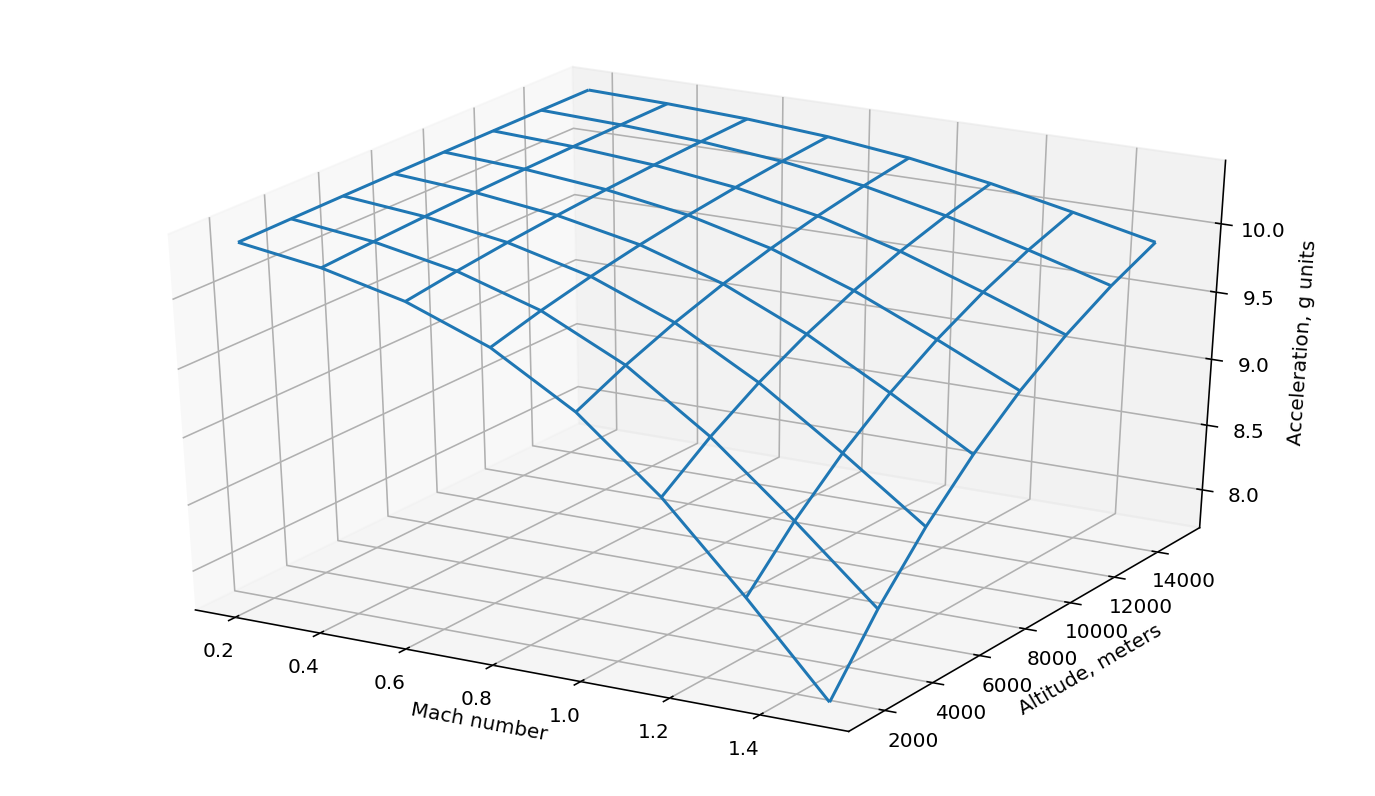

In [11]:
X = alt_plt
Y = mach_plt
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.set_zlim(6, 8)
ax.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_ylabel('Altitude, meters')
ax.set_xlabel('Mach number')
ax.set_zlabel('Acceleration, g units')
ax.plot_wireframe(Y, X, Z)
#plt.show()
plt.savefig('Launch_Accel_3d_profile.png', format='png', dpi=400)

#### Contour plots of launch acceleration vs altitude and Mach number

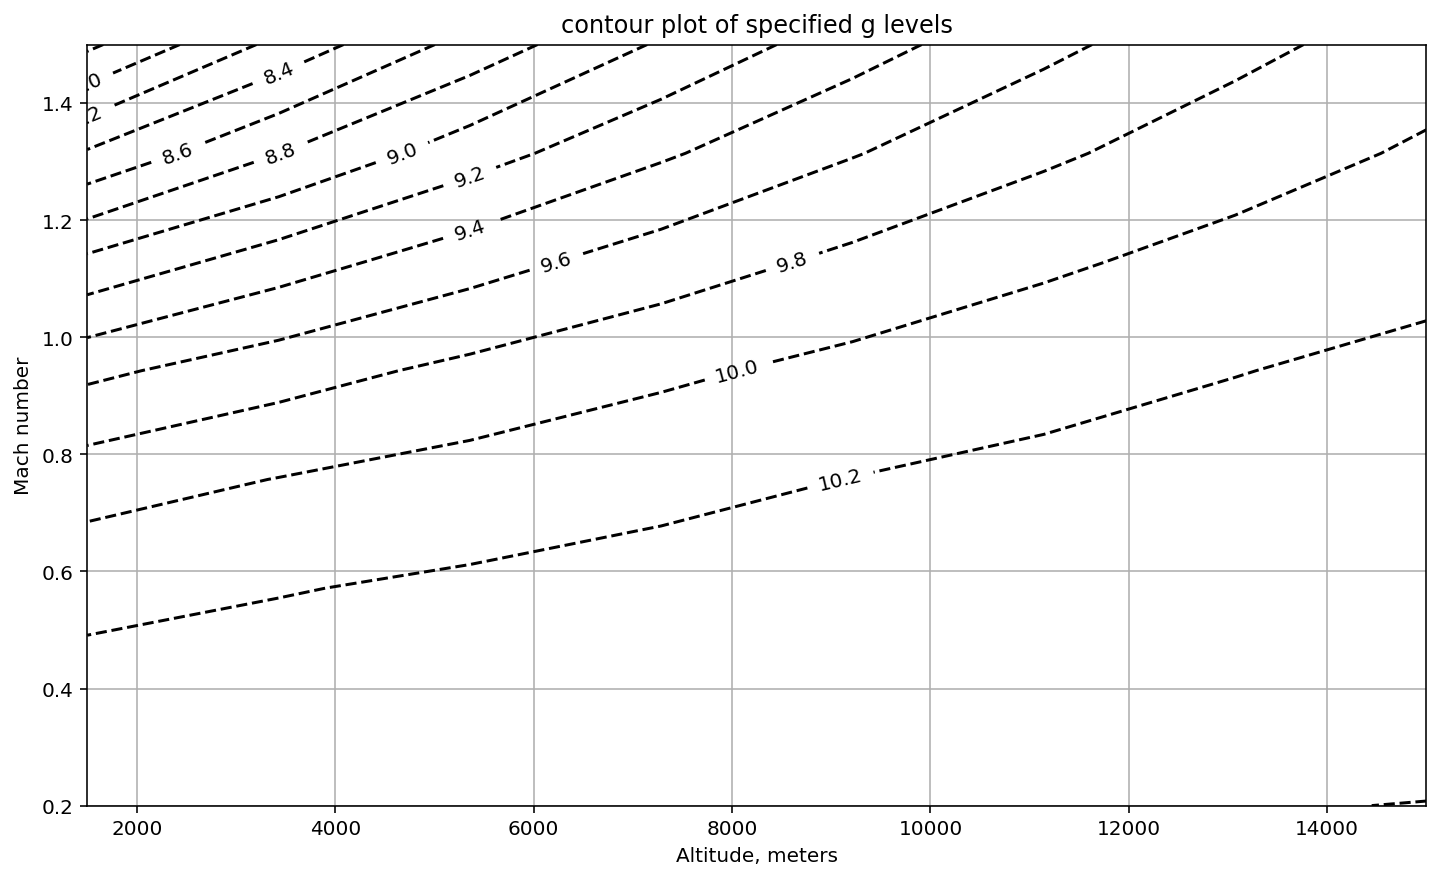

In [12]:
plt_list = np.arange(2,15.1,0.2)
cs = plt.contour(X,Y,Z,plt_list, colors = 'black', linestyles = 'dashed')
plt.clabel(cs, fmt = '%.1f', inline = True)
plt.xlabel('Altitude, meters')
plt.ylabel('Mach number')
plt.title('contour plot of specified g levels')
plt.grid()
#plt.show()
plt.savefig('Launch_Accel_contour_select_g_levels.png', format='png', dpi=400)

## Acceleration from 1st motion to t = 3 seconds
The following code cells calculate the acceleration from 1st motion to t=3 seconds.  After launch, the code assumes that the missile travels at constant altitude for at least 3 seconds and the motor thrust is constant during this time.  The weight of the missile decreases with time as the propellant undergoes combustion and reaction mass is expelled through the nozzle to develop thrust.  The decrease in weight is accounted for at each time step.  

The time step for the calculations is set to 0.1 seconds.  This number can be adjusted if higher resolution is needed.  A low altitude and high Mach number are used in the calculations since this combination has the worst case drag.

In [13]:
dt = 0.1   # time step
t = np.arange(0,3+dt,dt)

### Propellant  weight
The propellant burn rate is discussed in the papers, [here](http://www.dtic.mil/dtic/tr/fulltext/u2/261589.pdf) and [here](http://www.dtic.mil/dtic/tr/fulltext/u2/a405711.pdf).

Info on the Thiokol SR113-TC-1 dual-thrust solid-fueled rocket can be found in the presetation located [here](http://enu.kz/repository/2011/AIAA-2011-6941.pdf).
The following information was obtained from the presentation:   
Msl weight: 800 lbs  
Rocket motor weight: 394 lbs

To make the model simple, the burn rate will be modeled as propellant weight reduced linearly with time.  Propellant weight burns down to 0kg in 10 seconds (a guess). The rocket motor section without the propellant is usually very heavy since the structure needs to be strong enough to contain the high pressures during combustion. [Wikipedia](https://en.wikipedia.org/wiki/Rocket_propellant#Solid_propellants) says the mass ratio for a single-stage rocket might have a mass fraction of 90% propellant, 10% structure, but I am going to use a number in the 75% range since this seems more reasonable to me. An empty SR113-TC-1 seemed like it weighed about 100 pounds.  Two people were need to hold up the rocket motor while attaching it to the positioner.

In [14]:
rocket_motor_weight_lbs = 394
rocket_motor_weight = rocket_motor_weight_lbs * 0.453592 # convert to kg
propellant_weight_0 = rocket_motor_weight * 0.75  # initial propellant weight = 75% of motor weight, a guess

m = -propellant_weight_0/10  # slope of the propellant weight vs time due to propellant burn, a guess
propellant_weight = np.zeros(len(t))
for i in range(len(t)):
    propellant_weight[i] = m*t[i]+propellant_weight_0
    if propellant_weight[i] < 0:
        propellant_weight[i] = 0

print('rocket motor weight: {:.1f} kg'.format(rocket_motor_weight))
print('initial propellant weight: {:.1f} kg'.format(propellant_weight_0))
print('missile weight: {:.1f} kg'.format(msl_weight))
print('net missile weight: {:.1f} kg'.format(msl_weight - propellant_weight_0))

rocket motor weight: 178.7 kg
initial propellant weight: 134.0 kg
missile weight: 355.2 kg
net missile weight: 221.1 kg


In [15]:
# motor_thrust was set in cells above
# missile launch conditions
M = 1.5 # Mach number
altitude = 1500

t_c = np.interp(altitude, alt, T)  # temperature in C as a function of altitude
c_air = 331.3+0.606*t_c  # speed of sound, t_c is in degrees C
u =  M*c_air   # flow velocity relative to the object, mach*speed of sound
d = np.interp(altitude, alt, air_density)
Cd = np.interp(M, mach_num, drag_coef)

# create and initialize the arrays
v = np.zeros(len(t))  # velocity
s = np.zeros(len(t))  # displacement
a = np.zeros(len(t))  # acceleration
df = np.zeros(len(t)) # drag force
cd = np.zeros(len(t)) # drag coefficient

msl_net_weight = msl_weight - propellant_weight_0 # subtract initial propellant weight

# set the initial conditions at t=0
s[0] = 0
v[0] = u
cd[0] = Cd
df[0] = (d*cd[0]*area*v[0]**2)/2.0
a[0] = (motor_thrust-df[0])/(msl_net_weight+propellant_weight[0])

for i in range(len(t)-1):
    v[i+1] = v[i] + a[i]*dt  # velocity
    s[i+1] = s[i]+v[i+1]*dt+(a[i+1]*dt**2)/2  # displacement
    cd[i+1] = np.interp(v[i+1]/c_air, mach_num, drag_coef)  # Cd changes with Mach
    df[i+1] = (d*cd[i+1]*area*v[i+1]**2)/2.0  #drag force
    a[i+1] = (motor_thrust-df[i+1])/(msl_net_weight+propellant_weight[i+1])  # msl acceleration


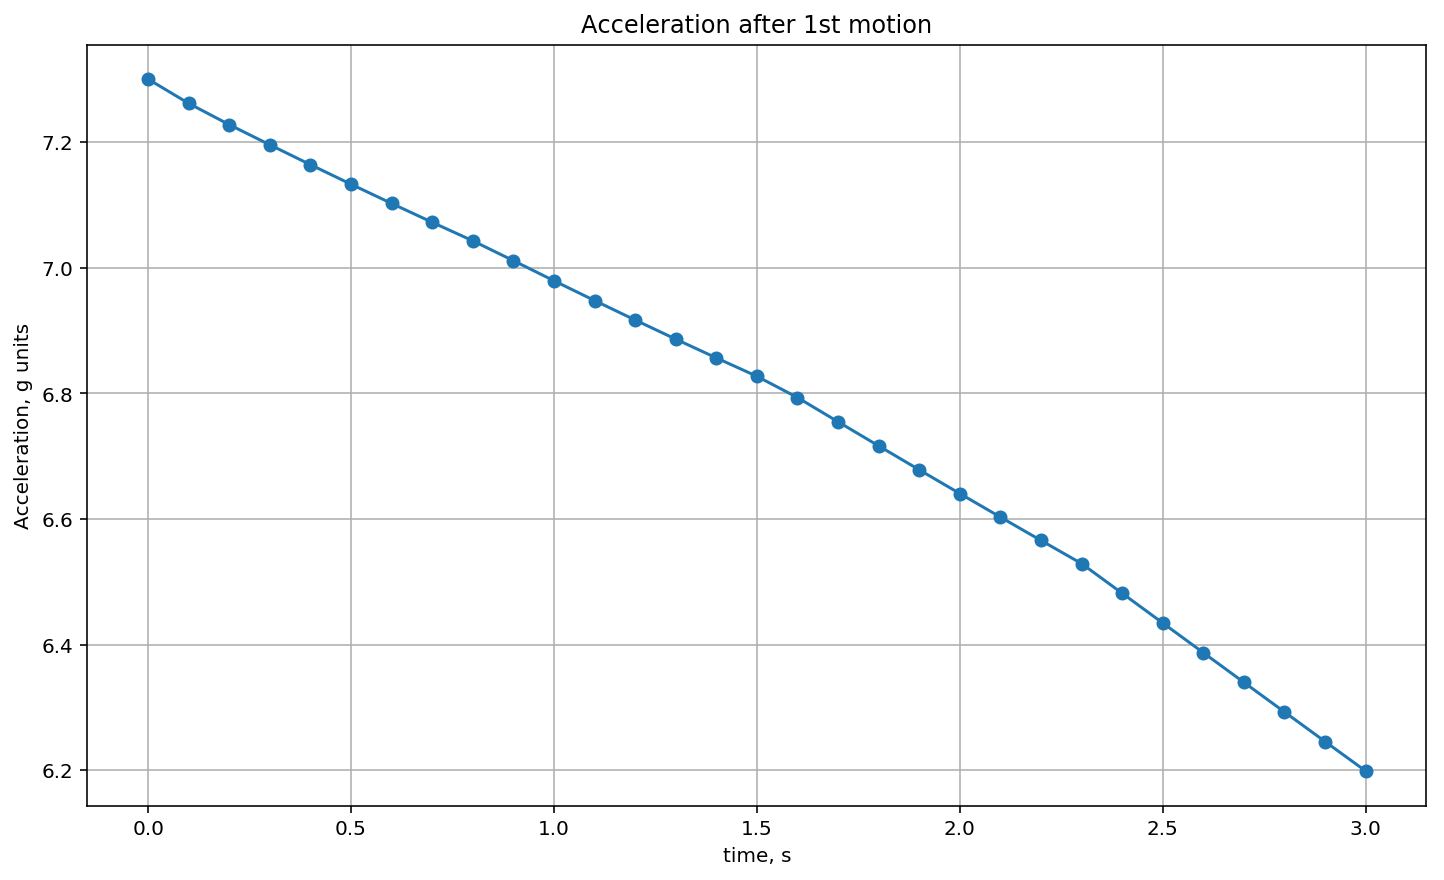

In [16]:
# plot acceleration vs time
plt.plot(t, a/9.80665,'-o')
plt.xlabel('time, s')
plt.ylabel('Acceleration, g units')
plt.title('Acceleration after 1st motion')
plt.grid()
#plt.show()
plt.savefig('Launch_Accel_launch.png', format='png', dpi=400)

Calculate time above acceleration threshold

In [17]:
threshold = 6.5 + 0.4  # threshold + max tolerance on g switch
g = a/9.80665

In [18]:
# turn the calculated acceleration profile into a function so the roots can be solved for.
def func(x):
    return np.interp(x, t, g)-threshold

In [19]:
x0 = np.array([1.25,2.5])  # initial guess at roots
ans2 = fsolve(func,x0)
print(ans2)

[ 1.25460921  1.25460921]


In [20]:
#print('time above threshold: {:.3f} seconds'.format(ans2[1]-ans2[0]))
print('time above threshold: {:.3f} seconds'.format(ans2[0]))

time above threshold: 1.255 seconds


## other plots

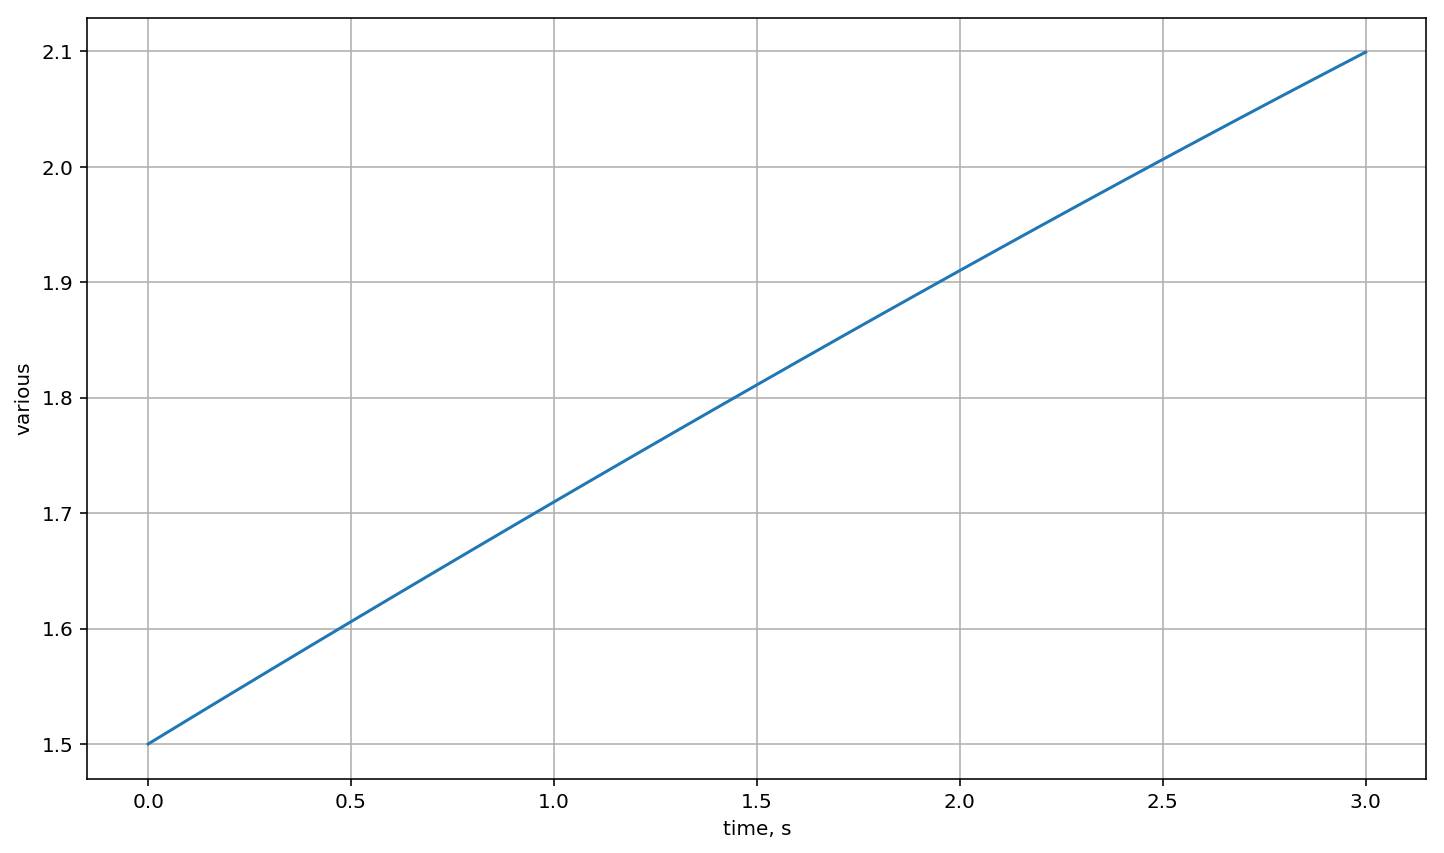

In [21]:
# plot acceleration, velocity and displacement
#plt.plot(t, cd,'-o')
#plt.plot(t, df,'-o')
#plt.plot(t, a,'-o')
#plt.plot(t, msl_net_weight+propellant_weight)
#plt.plot(t, s,'-o')
plt.plot(t, v/c_air)

plt.xlabel('time, s')
#plt.xlabel('Altitude, meters')
#plt.ylabel('Mach number')
#plt.title('contour plot of G-switch threshold, 6.5+/-0.4 g')
plt.ylabel('various')
#plt.legend(['df', 'a', 's', 'v'], loc='best')
plt.grid()
plt.show()
#plt.savefig('Launch_Accel_drag_coeff.png', format='png', dpi=400)